# Data Visualization

## Objectives

This notebook addresses **Business Requirement 1**:  
*Provide visual differentiation between healthy and mildew-affected cherry leaves.*

---

## Inputs (datasets)

- `inputs/mildew_dataset/cherry-leaves/train`
- `inputs/mildew_dataset/cherry-leaves/validation`
- `inputs/mildew_dataset/cherry-leaves/test`

---

## Outputs

### Dataset Overview

First we will get a statistical representation of the data. This includes:
- a total image count and class distribution (healthy or infected)
- we will show random sample images in a montage to give a visual of the dataset quality

### Image Statistics & Analysis
- Average image dimensions for preprocessing standardization
- Statistical comparison of grayscales between healthy and infected class (t-Test) maybe
- Visual analysis of class separation using Principal Component Analysis (PCA)

### Generated data
- pkl file to store Stores the averaged image dimensions, used to standardize input sizes during preprocessing.
- Visualizations: Key plots and graphics saved for later use in the Streamlit dashboard to support interactive data exploration.

# Import notebook packages

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imageio import imread
import joblib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Patch

# Add the ressource directory to our path to be able to load relevant functions
sys.path.append('./src')

e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set working directory and file path architecture for notebook
As the notebooks are set in a subfolder of this repo we need to adjust the working directory so files can be accessed properly. 

First we check our current working directory.

In [2]:
current_dir = os.getcwd()
current_dir

'e:\\Projects\\Code-I\\vscode-projects\\PP5-predictive_analysis\\jupyter_notebooks'

Now we can change the directory to the parent folder that contains the complete repo. We will also print our new working directory so we can check everything worked out as planned.

In [3]:
# Only change the directory if not already at the repo root
current_dir = os.getcwd()
target_dir = os.path.abspath(os.path.join(current_dir, os.pardir))  # One level up

# Check if we're already in the repo root
if os.path.basename(current_dir) == 'jupyter_notebooks':
    os.chdir(target_dir)
    current_dir = os.getcwd()
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Current working directory remains: {current_dir}")

Working directory set to: e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis


## Define data directories

In [4]:
# define variable for data directory
data_dir = os.path.join(os.getcwd(), 'inputs/datasets/raw/cherry-leaves')
# define variable for train set directory
train_dir = os.path.join(data_dir, 'train')
# define variable for test set directory
test_dir = os.path.join(data_dir, 'test')
# define variable for test set directory
val_dir = os.path.join(data_dir, 'validation')

## Check directory integrity

In [5]:
from exploration_visualization import check_structure
# Define the sets and labels for the dataset structure checkup
sets = ['train', 'test', 'validation']
labels = ['healthy', 'diseased']
# Check the integrity of the dataset structure
check_structure(data_dir, sets, labels)

'healthy' in 'train' is valid with 1472 images.
'diseased' in 'train' is valid with 1472 images.
'healthy' in 'test' is valid with 317 images.
'diseased' in 'test' is valid with 317 images.
'healthy' in 'validation' is valid with 315 images.
'diseased' in 'validation' is valid with 315 images.


## Define the output directory




In [6]:
# Set the current version
version = 'v1'
# Define the  directory
output_dir = os.path.join(current_dir, 'outputs', version)

# Check if the versioned output directory already exists
if os.path.exists(output_dir):
    print(f"Output directory '{output_dir}' already exists. "
          "Please create a new version.")
else:
    os.makedirs(output_dir)
    print(f"Created output directory: '{output_dir}'")

Output directory 'e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\outputs\v1' already exists. Please create a new version.


# Check distribution and balancing of the data

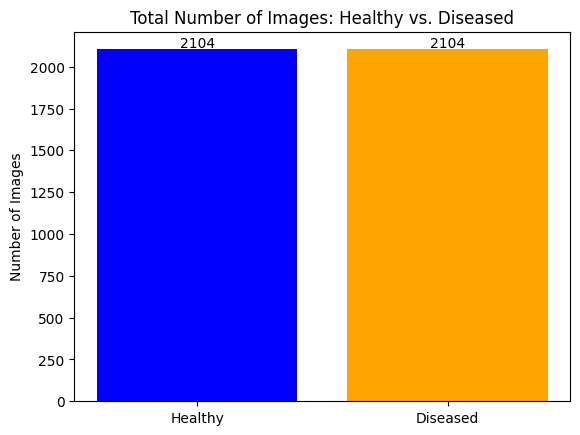

In [7]:
from exploration_visualization import count_images_for_class

splits = ["train", "validation", "test"]
healthy_total = count_images_for_class(data_dir, "healthy", splits)
diseased_total = count_images_for_class(data_dir, "diseased", splits)


plt.bar(["Healthy", "Diseased"], [healthy_total, diseased_total], color=["blue", "orange"])
plt.title("Total Number of Images: Healthy vs. Diseased")
plt.ylabel("Number of Images")

# Add values above bars
for i, count in enumerate([healthy_total, diseased_total]):
    plt.text(i, count + 10, str(count), ha='center')
plt.show()

### Visual Inspection: Sample Images from Test Set

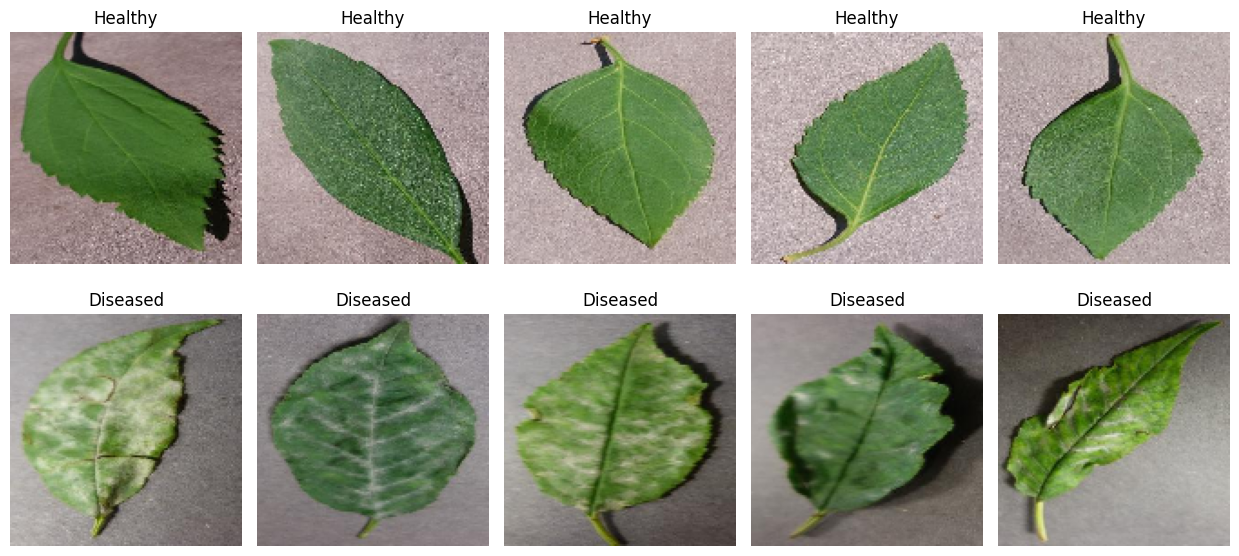

In [8]:
from exploration_visualization import preview_class_samples

# Preview samples from the training set
labels = ['healthy', 'diseased']
test_path = os.path.join(data_dir, "train")
preview_class_samples(test_path, labels, n_images=5, img_size=(128, 128))

## Image Dimension Analysis: Understanding Input Shape for Preprocessing

Before feeding image data into a neural network, it's essential to standardize the input dimensions. This step analyzes the native width and height of training images to:

- Assess consistency across samples

- Identify outliers or irregular shapes

- Determine an appropriate resize target (e.g., 128×128) for model efficiency

A scatter plot visualizes the distribution of image sizes, and red dashed lines indicate the average width and height across the training dataset.

This analysis ensures that resizing decisions are grounded in data, balancing between information retention and computational efficiency.

C:\Users\Ignor\AppData\Local\Temp\ipykernel_1812\3879310292.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)


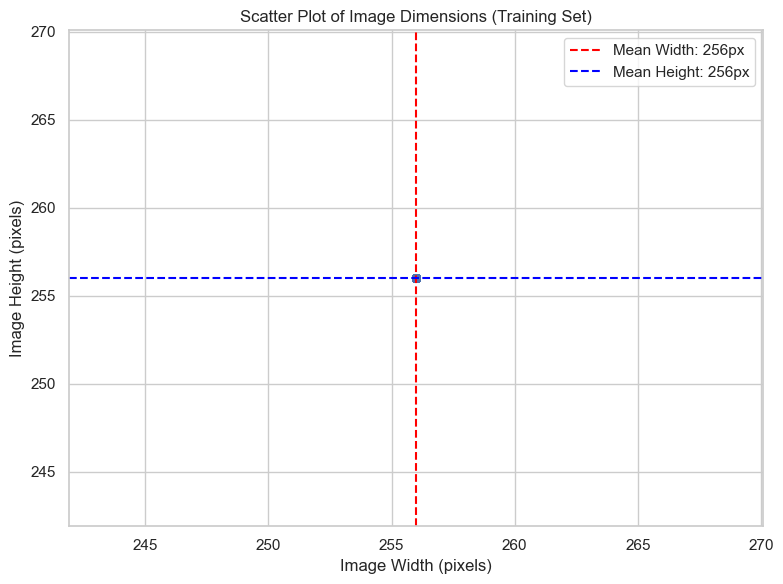

Average Image Dimensions: 256 x 256 pixels


In [9]:
# Collect image dimensions from training set
heights, widths = [], []

for label in labels:
    label_dir = os.path.join(train_dir, label)
    for image_name in os.listdir(label_dir):
        img_path = os.path.join(label_dir, image_name)
        img = imread(img_path)
        if img.ndim == 3:  # Ensure image has color channels
            h, w, _ = img.shape
            heights.append(h)
            widths.append(w)

# Compute mean dimensions
mean_height = int(np.mean(heights))
mean_width = int(np.mean(widths))

# Plot: scatter of all image dimensions
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=widths, y=heights, alpha=0.2, edgecolor=None)
plt.axvline(mean_width, color='red', linestyle='--', label=f"Mean Width: {mean_width}px")
plt.axhline(mean_height, color='blue', linestyle='--', label=f"Mean Height: {mean_height}px")
plt.xlabel("Image Width (pixels)")
plt.ylabel("Image Height (pixels)")
plt.title("Scatter Plot of Image Dimensions (Training Set)")
plt.legend()
plt.tight_layout()
plt.show()

# Summary
print(f"Average Image Dimensions: {mean_width} x {mean_height} pixels")

As we can observe all immages have the same dimensions of 256 x256 pixels.

## Image Size Analysis & Input Standardization

Evaluate dimension trends across classes and define preprocessing parameters like target shape and pixel scaling.

Now that we know the average size of all images it is time to consider ressources and efficiency. To make training more eficcient and ressource efficient we will rescale the images to 128x128 pixels. To do this, we will define an img_shape variable and save it as a .pkl file so we can make use of it in our consecutive steps.

In [10]:
# define image dimensions and save for reuse
img_shape = (128, 128, 3)
joblib.dump(value=img_shape ,
            filename=f"{output_dir}/img_shape.pkl")
img_shape

(128, 128, 3)

Next we will resize the images and load them into an array. The max_images_per_class variable is optional. As we are in the process of data exploration, we want to keep our sample size efficient, if you prefer looking at the whole set this variable can be set to None.

In [11]:
from exploration_visualization import load_and_preprocess_images

X, y = load_and_preprocess_images(
    data_dir=train_dir,
    target_size=img_shape[:2],
    max_images_per_class=40
)

print(X.shape, y.shape)

(80, 128, 128, 3) (80,)


In [12]:
from exploration_visualization import plot_class_image_statistics

plot_class_image_statistics(X, y, output_dir=output_dir, save_image=True)

==== Label: diseased ====
Image shape: (128, 128, 3)
Saved: e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\outputs\v1\avg_std_diseased.png

==== Label: healthy ====
Image shape: (128, 128, 3)
Saved: e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\outputs\v1\avg_std_healthy.png



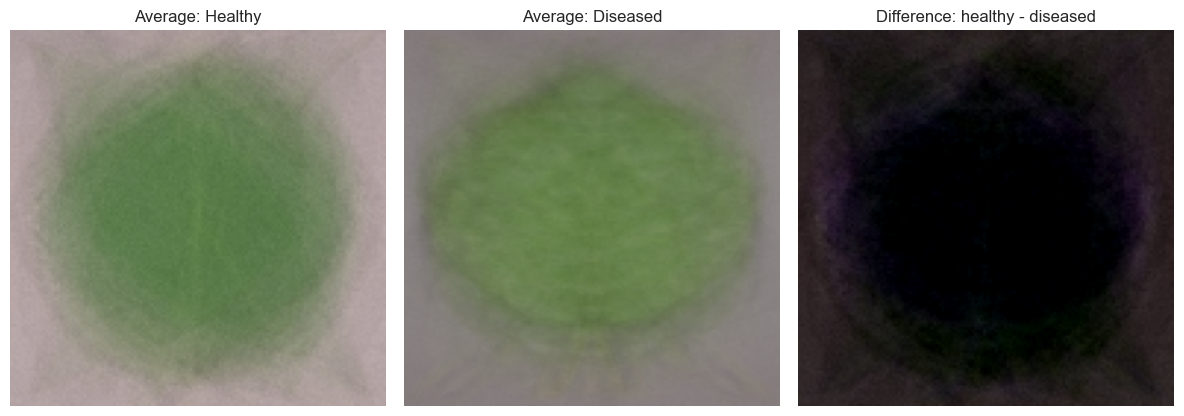

In [13]:
from exploration_visualization import compare_average_images
# Define the file path for saving the average difference image
compare_average_images(
    X=X,
    y=y,
    label_a='healthy',
    label_b='diseased',
    figsize=(12, 10),
    save_path=f"{output_dir}/avg_diff.png"
)

Previewing label: healthy


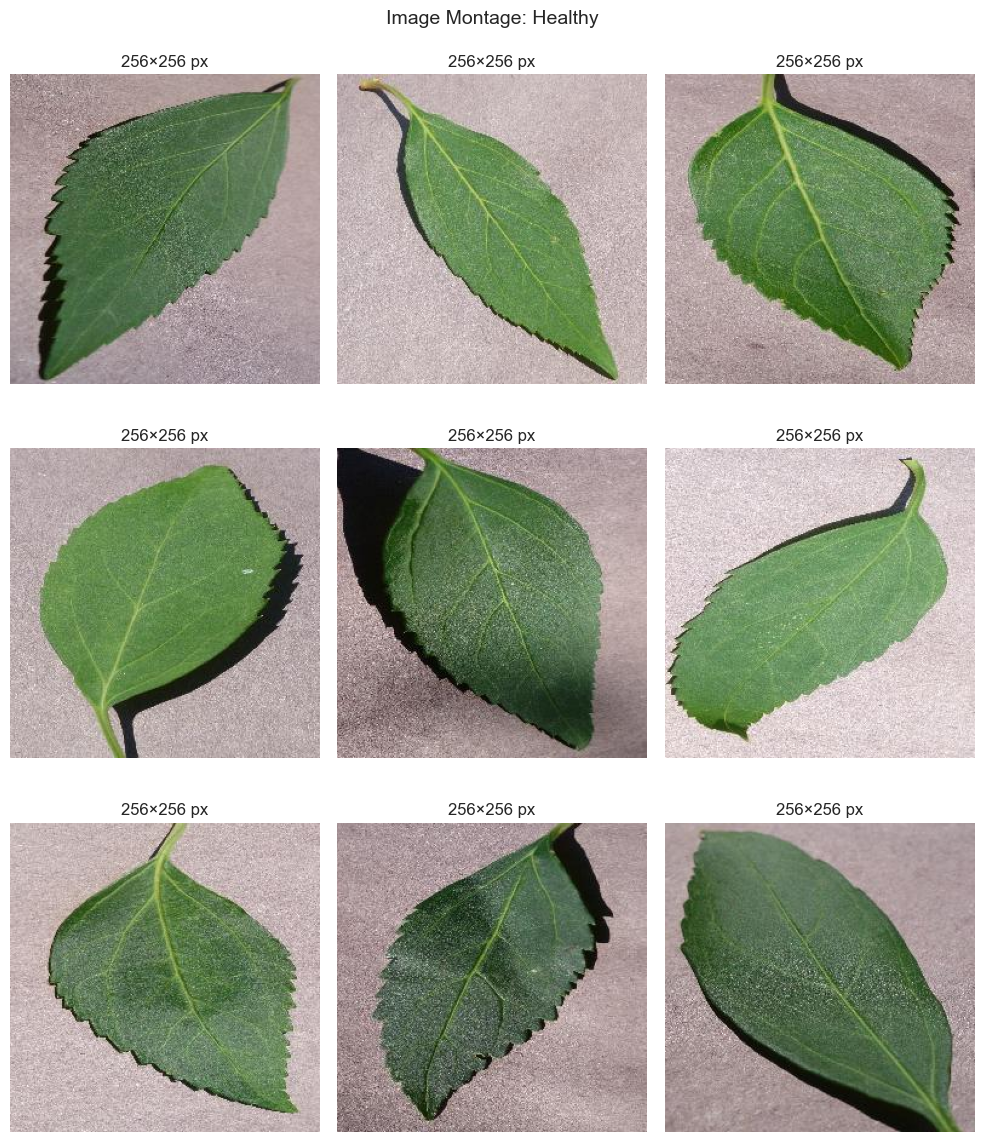



Previewing label: diseased


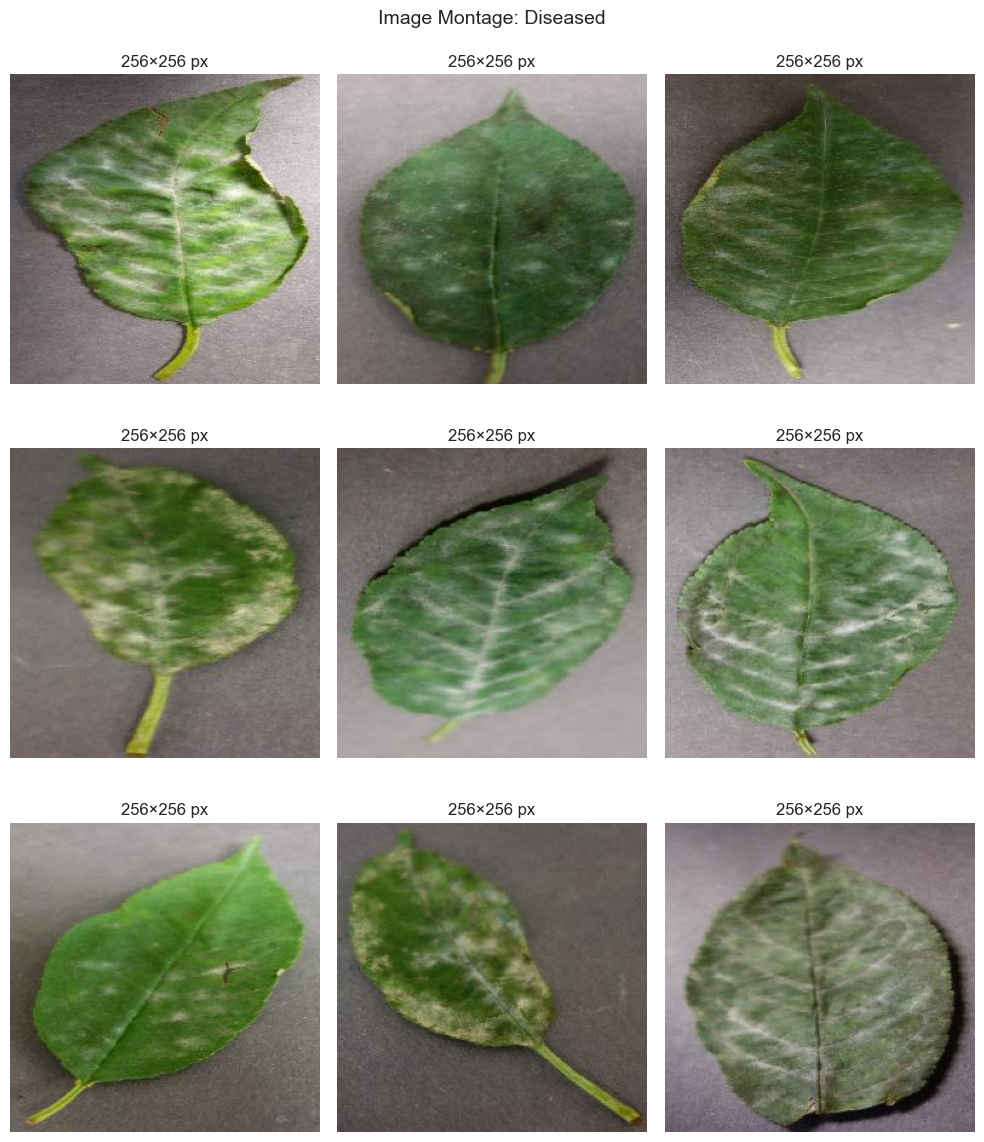

In [14]:
from exploration_visualization import image_montage

# Preview images from the training set
for label in labels:
    print(f"Previewing label: {label}")
    image_montage(
        dir_path=train_dir,
        label=label,
        nrows=3,
        ncols=3,
        figsize=(10, 12)
    )
    print("\n")

## Check Feature Separability

We will conduct a PCA (principal component Analysis) where we:
- Reduce image data to 2 or 3 principal components.

- Plot these components to see how well healthy vs diseased images separate.

Then we will try t-SNE (t-Distributed Stochastic Neighbor Embedding) because it outperforms a PCA in capturing non-linear relationships and is good for cluster structures.

And finally we will try to apply a UMAP (Uniform Manifold Approximation and Projection). The method is similar to t-SNE but faster and often better at preserving global structure.

## PCA

Parameters chosen: n_components=2

PCA is a linear method and doesn’t require much tuning. We selected 2 components simply to visualize the data in 2D for inspection of class separability. PCA captures directions of maximum variance, so this is a standard choice for visualization.

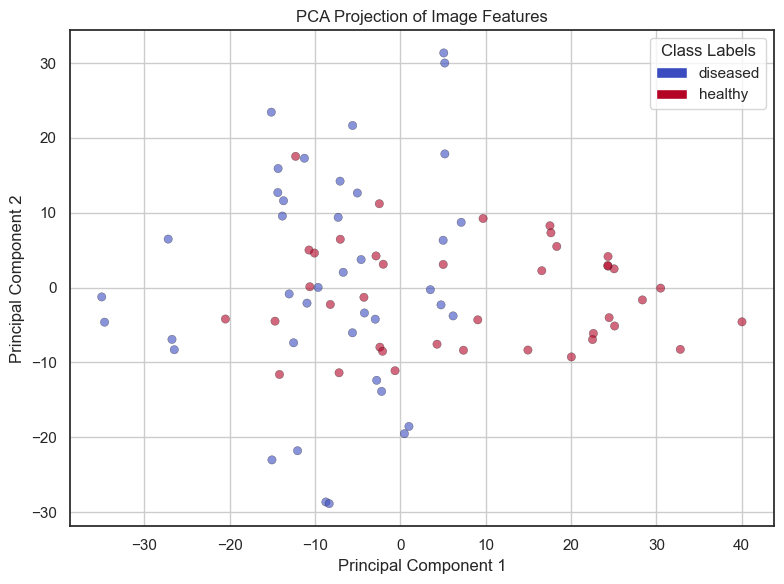

In [15]:
# Flatten images to et afor PCA and t-SNE
X_flat = X.reshape(X.shape[0], -1)

# Encode string labels to integers for coloring in plots
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_encoded,
    cmap="coolwarm",
    alpha=0.6,
    edgecolor='k',
    linewidth=0.3
)

# Get unique label indices and corresponding colors from the scatter plot
unique_labels = np.unique(y_encoded)
colors = scatter.cmap(scatter.norm(unique_labels))

# Create legend using actual colors used in scatter
legend_elements = [
    Patch(facecolor=colors[i], label=class_names[i])
    for i in range(len(class_names))
]

# Final plot styling
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Image Features")
plt.legend(handles=legend_elements, title="Class Labels")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/PCA.png", bbox_inches="tight", dpi=150)
plt.show()

PCA Projection (Linear dimensionality reduction)

Observations:

The PCA scatter plot shows significant overlap between the two classes in the central region.

There's a slight tendency for each class to lean to one side (healthy toward the right, diseased more spread left), but it's not strongly separated.

This suggests that linear combinations of features are not sufficient for clear class separation.

## t-SNE

Parameters chosen:

    n_components=2: For 2D visualization
    
    perplexity=30: Balances local vs. global structure

    n_iter=1000: Sufficient for convergence

    random_state=42: Ensures reproducibility

Why:

    Perplexity (30) is a commonly used default that works well on datasets of moderate size. It affects how many nearest neighbors influence each point’s position.

    Iteration count was increased to allow the method to stabilize and avoid premature convergence.

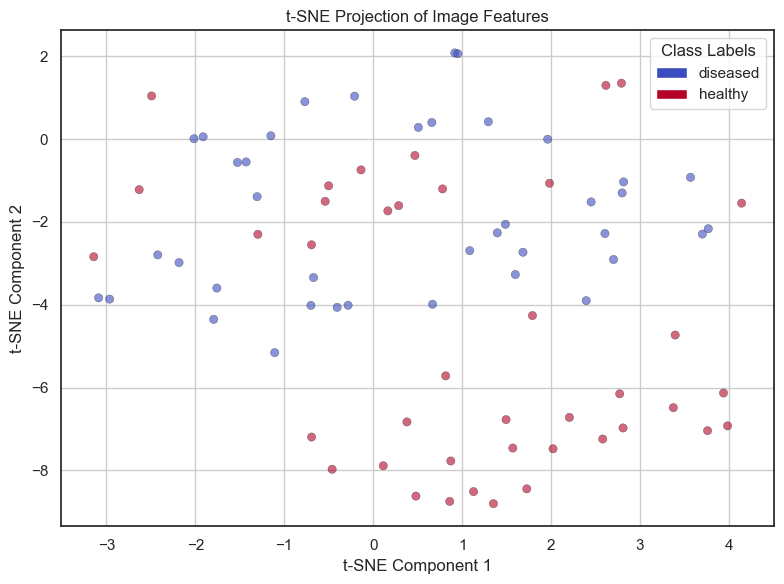

In [16]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=y_encoded,
    cmap="coolwarm",
    alpha=0.6,
    edgecolor='k',
    linewidth=0.3
)

# Generate proper legend using t-SNE colors
unique_labels = np.unique(y_encoded)
colors = scatter.cmap(scatter.norm(unique_labels))
legend_elements = [
    Patch(facecolor=colors[i], label=class_names[i])
    for i in range(len(class_names))
]

# Final styling
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Projection of Image Features")
plt.legend(handles=legend_elements, title="Class Labels")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/t-SNE.png", bbox_inches="tight", dpi=150)
plt.show()

t-SNE Projection (Nonlinear dimensionality reduction)

Observations:

t-SNE reveals better-defined local groupings, especially for the healthy class (red), which appears more compact and clustered toward the lower part of the graph.

The diseased class (blue) is more dispersed, but it avoids that lower region, indicating some nonlinear separability.

There's still some inter-class mixing, but the spatial distribution indicates that a nonlinear model (like CNN or tree-based) could better exploit these differences.

## UMAP

Parameters chosen:

    n_neighbors=15: Balances local vs. global structure

    min_dist=0.1: Controls how tightly points are packed

    metric='euclidean': Standard for continuous data

    random_state=42: For reproducibility

Why:

    n_neighbors=15 offers a good balance between capturing local detail and maintaining the global manifold structure.

    min_dist=0.1 keeps clusters tighter for better visual separation.

    UMAP is sensitive to these hyperparameters, but these values are well-suited for general-purpose visualizations.

e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


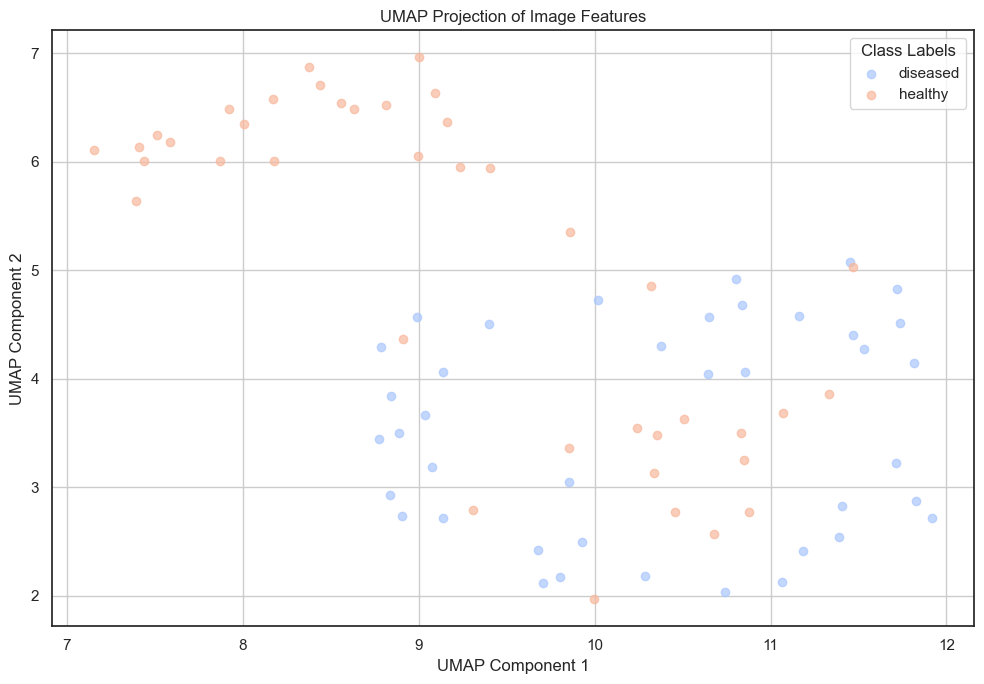

In [17]:
# Initialize UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
X_umap = umap_model.fit_transform(X_flat)

# Plotting
plt.figure(figsize=(10, 7))
palette = sns.color_palette("coolwarm", len(class_names))
colors = [palette[label] for label in y_encoded]

for i, class_name in enumerate(class_names):
    idx = y_encoded == i
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=class_name, color=palette[i], alpha=0.7)

plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP Projection of Image Features")
plt.legend(title="Class Labels")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/UMAP.png", bbox_inches="tight", dpi=150)
plt.show()

UMAP Projection (Nonlinear dimensionality reduction)

Observations:

Class Separation: The "diseased" and "healthy" samples form distinct clusters, with minimal overlap. This implies your features contain highly discriminative information.

Non-linear Structure: UMAP, like t-SNE, preserves local and some global structure, but does so with better preservation of global topology. The fact that the groups remain separate in this projection suggests:


# Conclusion & Next Steps

This notebook marks a successful end to the Exploratory Data Analysis (EDA) phase, laying a solid foundation for downstream modeling and deployment.

## Key Findings from EDA
### Dataset Composition & Quality

The dataset is balanced across classes, supporting fair model evaluation.

Bar plots and image montages confirmed consistency in labeling and image quality across categories.

### Image Shape & Preprocessing

Original images averaged around 256×256 pixels, resized to 128×128 for computational efficiency.

Resizing and normalization ensure consistent model inputs across batches.

### Class Variability & Statistical Evidence

Mean image analysis showed that healthy leaves are visually more uniform, while diseased leaves exhibit greater texture and intensity variation.

### Feature Space Projections

We explored multiple dimensionality reduction techniques to visualize class separability in the high-dimensional feature space:

    PCA revealed modest linear separation — supporting the hypothesis that deep features can help improve performance, but linear models may be limited.

    t-SNE uncovered nonlinear structures between classes, although overlap persisted — confirming that the task is not trivial.

    UMAP showed the clearest class separation, capturing the intrinsic geometry of the data and suggesting that the feature space is highly informative for classification.

These projections validate the viability of applying nonlinear classifiers, such as tree-based models or neural networks, to achieve high performance.

### Implications for Modeling

Based on the observed structure and separability:

    High classification performance is achievable with appropriate models.

    Even simple classifiers (e.g., Logistic Regression, SVMs) may perform well.

    Tree-based models (e.g., Random Forest, XGBoost) will likely excel given the nonlinear nature of the data.

    UMAP (or PCA) could be used as a preprocessing step to reduce dimensionality, accelerate training, and potentially enhance generalization.

    If the UMAP structure generalizes across data splits, overfitting risk will be minimal, especially with proper regularization and early stopping.

## Next Steps
### Data Preprocessing

    Apply augmentation (e.g., flips, rotations, color jitter) to improve model robustness.

    Ensure consistent image shape and normalization across all data splits.

    Stratify and validate train/val/test splits to preserve class balance.

### Model Training & Evaluation

    Train a baseline CNN, followed by iterative hyperparameter tuning.

    Evaluate using confusion matrices, ROC curves, and classification reports.

    Plot learning curves to monitor training dynamics and overfitting risk.

### Deployment Preparation

    Save the final model architecture and weights.

    Develop an interactive Streamlit dashboard for real-time prediction and visualization, incorporating UMAP/PCA plots and model outputs.

This concludes the Data Visualization & EDA phase.